<font color='blue'> **10_Zaidel Problem** </font> 

In [49]:
import flopy ; import matplotlib.pyplot as plt ; import numpy as np             ; from pathlib import Path; from flopy.plot.styles import styles 
from modflow_devtools.misc import get_env      ; write=get_env("WRITE", True)   ; run=get_env("RUN", True)
output_folder = Path("./10_ex-gwf-zaidel") ; output_folder.mkdir(exist_ok=True) ; sim_name = "zaidel"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name 

In [50]:
length_units = "meters" ; time_units = "days"                              ; parameters = {"zaidel_1": {"H2": 1.0},"zaidel_2": {"H2": 10.0}}
nlay = 1 ;nrow = 1  ;ncol = 200  ;delr = 5.0  ;delc = 1.0  ;top = 25.0                  ;strt = 23.0  ; icelltype = 1  ;k11 = 0.0001  ;H1 = 23.0  
nper = 1 ;nouter=500 ;ninner=50 ;hclose=1e-9 ;rclose=1e-6 ; tdis_ds = ((1.0, 1, 1.0),) ; botm = np.zeros((nlay, nrow, ncol), dtype=float)   ; base = 20.0
for j in range(ncol):  
    botm[0, :, j] = base
    if j + 1 in (40, 80, 120, 160):                  base -= 5

In [51]:
def build_models(H2=1.0):
    chd_spd = [[0, 0, 0, H1],[0, 0, ncol - 1, H2]]   ; head_filerecord = f"{sim_name}.hds"
    sim = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=output_folder, exe_name="mf6")
    flopy.mf6.ModflowTdis       (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms    (sim,linear_acceleration="bicgstab",outer_maximum=nouter,outer_dvclose=hclose,
                             inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf  (sim, modelname=sim_name, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf (gwf,icelltype=icelltype,k=k11)
    flopy.mf6.ModflowGwfic  (gwf, strt=strt)
    flopy.mf6.ModflowGwfchd (gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord=head_filerecord,saverecord=[("HEAD", "ALL")])
    return sim
def write_models(sim, silent=True):   sim.write_simulation(silent=silent)
def run_models(sim, silent=True):     success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx] ; params = parameters[key].copy() ; sim = build_models(**params)
    if write:    write_models(sim, silent=silent)
    if run:      run_models(sim, silent=silent)
scenario(1)  #; scenario(1)

In [52]:
sim = flopy.mf6.MFSimulation.load(sim_ws = output_folder ,exe_name=exe_name ,verbosity_level=0)
gwf = sim.get_model(sim_name)           ; xedge = gwf.modelgrid.xvertices[0] ; zedge = np.array([botm[0, 0, 0]] + botm.flatten().tolist())
hobj = gwf.output.head()                ; head = hobj.get_data() ; vmin, vmax = 0, 25

extents = (0, ncol * delr, -1, 25.0)    

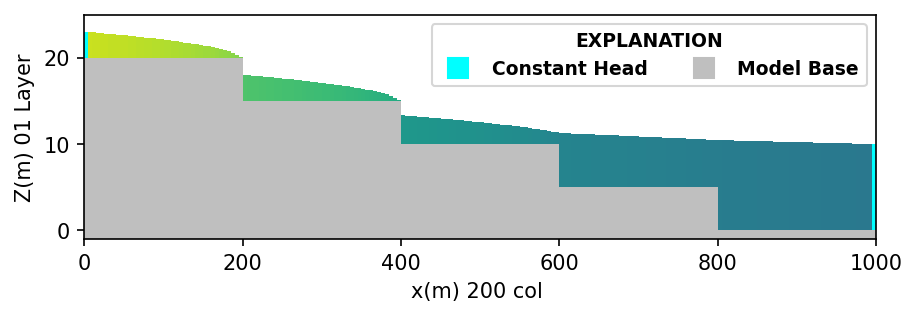

In [53]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6, 2),dpi=150,constrained_layout=True,sharey=True)  ; ax.set_xlim(extents[:2]) ; ax.set_ylim(extents[2:])
fmp = flopy.plot.PlotCrossSection(model=gwf, ax=ax, extent=extents, line={"row": 0}) ; ax.fill_between(xedge, zedge, y2=-1, color="0.75", step="pre", lw=0.0)
plot_obj = fmp.plot_array(head, head=head, vmin=vmin, vmax=vmax)                     ; fmp.plot_bc("CHD", color="cyan", head=head)
ax.set_xlabel("x(m) 200 col ") ; ax.set_ylabel("Z(m) 01 Layer")

ax.plot(-1000,-1000,lw=0,marker="s",ms=10,mfc="cyan",mec="cyan",label="Constant Head")
ax.plot(-1000,-1000,lw=0,marker="s",ms=10,mfc="0.75",mec="0.75",label="Model Base")          ;styles.graph_legend(ax, ncol=2, loc="upper right")
cbar.ax.tick_params(size=0)                                                          ; cbar.ax.set_xlabel(r"Head, $m$", fontsize=3) ; plt.show()